# BJT 三极管基础知识复习

In [1]:
%matplotlib inline
%load_ext tikzmagic

from math import exp, log, log10
import numpy as np
from matplotlib import pyplot as plt
import ngspyce as ng

# kΩ μA

def para(r1, r2):
  return (r1*r2) / (r1 + r2)

In [7]:
def print_op(show_ib=True, show_ie=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if '[i' in k or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ie]' in k and not show_ie:
            continue
        if '[ib]' in k and not show_ib:
            continue
        current = op[k][0]
        k = k.replace('q.x.', '')
        k = k.replace('r.x.', '')
        if abs(current) > 1e-3:
            print('%10s = %8.3f mA' % (k, 1e3*current))
        else:
            print('%10s = %8.3f uA' % (k, 1e6*current))
    elif '[g' in k:
        gm = op[k][0]
        if gm > 10e-3:
            print('%10s = %8.3f mS' % (k, 1e3 * gm))
        else:
            print('%10s = %8.3f uS' % (k, 1e6 * gm))
    else:  # Voltage
        voltage = op[k][0]
        k = k.replace('x.', '')
        if abs(voltage) > 10e-3:
            print('%10s = %8.4f V' % (k, voltage))
        else:
            print('%10s = %8.1f uV' % (k, 1e6*voltage))


## 基本模型
$\newcommand{\li}[1]{{i_\mathrm{#1}}}$
$\newcommand{\ui}[1]{{I_\mathrm{#1}}}$
$\newcommand{\lv}[1]{{v_\mathrm{#1}}}$
$\newcommand{\uv}[1]{{V_\mathrm{#1}}}$
$\newcommand{\sm}[2]{{{#1}_\mathrm{#2}}}$

模拟电路对数学要求不高，只在推导时用一点点微积分知识（[链式求导法则](https://zh.wikipedia.org/wiki/%E9%93%BE%E5%BC%8F%E6%B3%95%E5%88%99) / [Chain rule](https://en.wikipedia.org/wiki/Chain_rule)），在确定小信号条件时用到了[泰勒展开](https://zh.wikipedia.org/wiki/%E6%B3%B0%E5%8B%92%E7%BA%A7%E6%95%B0)。

以下是 SPICE 采用的物理常数，注意 SPICE 用的 $k$ / $q$ 常数是旧值。

In [6]:
ng.vectors()

{'planck': array([6.62607004e-34]),
 'boltz': array([1.38064852e-23]),
 'echarge': array([1.60217662e-19]),
 'kelvin': array([-273.15]),
 'i': array([0.+1.j]),
 'c': array([2.99792458e+08]),
 'e': array([2.71828183]),
 'pi': array([3.14159265]),
 'FALSE': array([0.]),
 'no': array([0.]),
 'TRUE': array([1.]),
 'yes': array([1.])}

In [12]:
boltz = 1.38064852e-23
echarge = 1.60217662e-19
kelvin = 273.15

room_temperature = 27
Vt = boltz * (room_temperature + kelvin) / echarge
print(Vt)

0.02586491702007235


[2019 年重新定义 SI 基本单位](https://en.wikipedia.org/wiki/2019_redefinition_of_the_SI_base_units)之后，

* 新的 [Boltzmann常数](https://en.wikipedia.org/wiki/Boltzmann_constant)是精确值 $1.380\,649\times 10^{-23}$ J/K.
* 新的[基本电荷](https://en.wikipedia.org/wiki/Elementary_charge)也是精确值 $ 1.602\,176\,634\times 10 ^{-19}$ C.

### Ebers-Moll 大型号模型

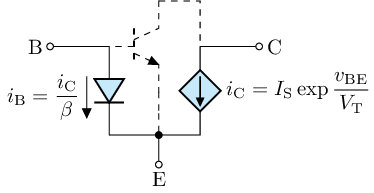

In [4]:
%%tikz -ct
\ctikzset{european voltages, american currents, european resistors}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\ctikzset{diodes/fill=cyan!20, csources/fill=cyan!20}

\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\lv}[1]{\ensuremath{v_\mathrm{#1}}}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}

\draw [dashed] (0, 0) node [npn] (Q) {}; 
\draw (Q.B) to [D, bipoles/length=1cm] ++(0, -1.5) coordinate (E);
\draw (Q.B) to [short, -o] ++(-1, 0) node [left] {B};
\draw [dashed] (Q.E) to [short] (Q.E |- E); 
\draw (Q.E |- E) to [short, *-o] ++(0, -0.5) node [below] {E};
\draw (Q) ++(0.7, 0) coordinate (C) 
  to [american controlled current source, l={$\li{C}=\ui{S}\exp\displaystyle\frac{\lv{BE}}{\uv{T}}$}, bipoles/length=1cm] (C|-E)
  -- (E);
\draw (C) to [short, -o] ++(1, 0) node [right] {C};
\draw [dashed] (Q.C) -| (C);
\draw (Q.B)++(-0.1,0) to [open, f_={$\li{B}=\displaystyle\frac{\li{C}}{\beta}$}] ++(0, -1);

In [49]:
Is = 1e-15
Vbe = 0.7
Ic = Is * exp(Vbe / Vt)
gm = Ic / Vt
print('Ic', Ic)
print('gm', gm)

Ic 0.0005670346694806257
gm 0.02192292629590039


In [2]:
ng.circ('''
  Q  c b 0 NPN
  Vc c 0 1V
  Vb b 0 0.7V
  .model NPN NPN(IS=1fA BF=100)
  .save all @q[gm] @q[gpi]
''')
ng.operating_point()
# print_op()

{'@q[gpi]': array([0.00021923]),
 '@q[gm]': array([0.02192293]),
 'vc#branch': array([-0.00056703]),
 'vb#branch': array([-5.67034717e-06]),
 'b': array([0.7]),
 'c': array([1.])}

In [23]:
Ic2 = -ng.vector('vc#branch')[0]
print('%.5f uA (SPICE)' % (Ic2 * 1e6))
print('%.5f uA (EM)' % (Ic * 1e6))

567.03468 uA (SPICE)
567.03467 uA (EM)


In [20]:
Ib = -ng.vector('vb#branch')[0]
print('%.7f uA (SPICE)' % (Ib * 1e6))
print('%.7f uA (EM)' % (Ic / 100 * 1e6))

5.6703472 uA (SPICE)
5.6703467 uA (EM)


In [36]:
gm2 = ng.vector('@q[gm]')[0]
print('%.5f mS (SPICE)' % (gm2 * 1e3))
print('%.5f mS (EM)' % (gm * 1e3))

21.92293 mS (SPICE)
21.92293 mS (EM)


#### Curve tracer

### Early effect

Affects $\li{C}$, not $\li{B}$

$\li{C0}=\ui{S}\exp\dfrac{\lv{BE}}{\uv{T}}$

$\li{C}=\li{C0}\Big(1+\dfrac{\lv{CE}}{\uv{A}}\Big)=\ui{S}\exp\dfrac{\lv{BE}}{\uv{T}}\Big(1+\dfrac{\lv{CE}}{\uv{A}}\Big)$

$\li{B}=\dfrac{\li{C0}}{\beta} = \dfrac{\ui{S}}{\beta}\exp\dfrac{\lv{BE}}{\uv{T}}$

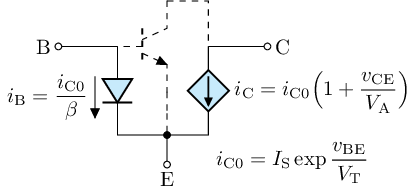

In [66]:
%%tikz -ct -p amsmath
\ctikzset{european voltages, american currents, european resistors}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\ctikzset{diodes/fill=cyan!20, csources/fill=cyan!20}

\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\lv}[1]{\ensuremath{v_\mathrm{#1}}}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}

\draw [dashed] (0, 0) node [npn] (Q) {}; 
\draw (Q.B) to [D, bipoles/length=1cm] ++(0, -1.5) coordinate (E);
\draw (Q.B) to [short, -o] ++(-1, 0) node [left] {B};
\draw [dashed] (Q.E) to [short] (Q.E |- E); 
\draw (Q.E |- E) to [short, *-o] ++(0, -0.5) node [below] {E};
\draw (Q) ++(0.7, 0) coordinate (C) 
  to [american controlled current source, l={$\li{C}=\li{C0}\Big(1+\dfrac{\lv{CE}}{\uv{A}}\Big)$}, bipoles/length=1cm] (C|-E)
  node [below right] {$\li{C0}=\ui{S}\exp\displaystyle\frac{\lv{BE}}{\uv{T}}$}
  -- (E);
\draw (C) to [short, -o] ++(1, 0) node [right] {C};
\draw [dashed] (Q.C) -| (C);
\draw (Q.B)++(-0.1,0) to [open, f_={$\li{B}=\displaystyle\frac{\li{C0}}{\beta}$}] ++(0, -1);

In [3]:
ng.circ('''
  Q  c b 0 NPN
  Vc c 0 10V
  Vb b 0 0.7V
  .model NPN NPN(IS=1fA BF=100 VAF=150)
  .save all @q[gm]
''')
ng.operating_point()
# print_op()

{'@q[gm]': array([0.02327837]),
 'vc#branch': array([-0.00060219]),
 'vb#branch': array([-5.67033817e-06]),
 'b': array([0.7]),
 'c': array([10.])}

But, SPICE uses $\lv{CB}$, not $\lv{CE}$.

In [26]:
Vcb = 10 - Vbe
Vaf = 150
Ic3 = Ic * (1 + Vcb / Vaf)

Ic2 = -ng.vector('vc#branch')[0]
print('%.5f uA (SPICE)' % (Ic2 * 1e6))
print('%.5f uA (EM)' % (Ic3 * 1e6))

602.19085 uA (SPICE)
602.19082 uA (EM)


In [27]:
Ib = -ng.vector('vb#branch')[0]
print('%.7f uA (SPICE)' % (Ib * 1e6))
print('%.7f uA (EM)' % (Ic / 100 * 1e6))

5.6703382 uA (SPICE)
5.6703467 uA (EM)


In [42]:
gm3 = ng.vector('@q[gm]')[0]
print('gm %.3f mS (SPICE)' % (gm3 * 1e3))
print('gm %.3f mS (EM)' % (1e3 * Ic3 / Vt))

gm 23.278 mS (SPICE)
gm 23.282 mS (EM)


#### Curve tracer

### 低频小信号 hybrid-pi 模型

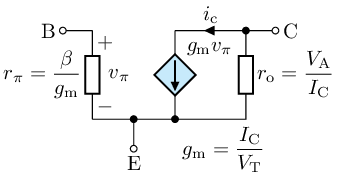

In [5]:
%%tikz -ct
\ctikzset{european resistors, american voltages}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\ctikzset{diodes/fill=cyan!20, csources/fill=cyan!20}
\newcommand{\sm}[2]{\ensuremath{{#1}_\mathrm{#2}}}
    
\draw (0,0) to [R, l_={$r_\pi=\displaystyle\frac{\beta}{\sm{g}{m}}$}, v^>={$v_\pi$}, bipoles/length=0.8cm] ++(0, -1.5) coordinate (E);
\draw (0,0) to [short, -o] ++(-0.5, 0) node [left] {B};
%\draw [dashed] (Q.E) to [short] (Q.E |- E);
\draw (E) ++(0.7, 0) to [short, *-o] ++(0, -0.5) node [below] {E};
\draw (1.4, 0) coordinate (C)
  node [below right=2pt] {$\sm{g}{m}v_\pi$}
  to [american controlled current source, bipoles/length=1cm] (C|-E) node [circ] {}
  node [below right] {$\sm{g}{m}=\displaystyle\frac{\sm{I}{C}}{\sm{V}{T}}$};
\draw (C) to [short, i<={\sm{i}{c}}] ++(1.2, 0) coordinate (D)
  to [R, l={$\sm{r}{o}=\displaystyle\frac{\sm{V}{A}}{\sm{I}{C}}$}, bipoles/length=0.8cm] (D|-E)-- (E);
\draw (D) to [short, *-o] ++(0.5, 0) node [right] {C};

跨导 Transconduance $\sm{g}{m}$

如果基极电压改变了 $\Delta \lv{BE}$，那么集电极电流将改变 $\Delta \li{C}$，跨导 $\sm{g}{m}$ 表示二者的比值，$\sm{g}{m}$ 越大，表明相同 $\Delta \lv{BE}$ 下 $\Delta \li{C}$ 越大，也就是电流的放大能力越大。

$\sm{g}{m}=\dfrac{\Delta \li{C}}{\Delta \lv{BE}} = \dfrac{\mathrm{d}\, \ui{S}\exp \dfrac{\lv{BE}}{\uv{T}}}{\mathrm{d}\, \lv{BE}} = \dfrac{1}{\uv{T}}\ui{S}\exp \dfrac{\uv{BEQ}}{\uv{T}} = \dfrac{\ui{CQ}}{\uv{T}}$

$\sm{g}{m} \propto \ui{CQ}$，$\sm{g}{m} \propto \dfrac{1}{T}$，
可见对于 BJT 来说，$\sm{g}{m}$ 只跟 $\ui{CQ}$ 和温度 $T$ 有关。
温度越高 $\sm{g}{m}$ 越小，为了维持 $\sm{g}{m}$ 稳定，有时需要设法让 $\ui{CQ} \propto T$ 。

In [4]:
ng.circ('''
  Q  c b 0 NPN
  Ic 0 c 600u
  Vb b 0 0.7V
  .model NPN NPN(IS=1fA BF=100 VAF=150)
  .save all @q[gm] @q[ic]
''')
ng.operating_point()
# print_op()

{'@q[ic]': array([0.0006]),
 '@q[gm]': array([0.02319366]),
 'vb#branch': array([-5.67033875e-06]),
 'b': array([0.7]),
 'c': array([9.42044675])}

In [14]:
Is = 1e-15
Vbe = 0.7
Ic = 0.6e-3
gm = Ic / Vt
gm2 = ng.vector('@q[gm]')[0]
print('gm %.4f mS (SPICE)' % (gm2 * 1e3))
print('gm %.4f mS (EM)' % (gm * 1e3))
print('Delta gm', gm - gm2)

gm 23.1937 mS (SPICE)
gm 23.1974 mS (EM)
Delta gm 3.7809210074110644e-06


输入阻抗 Input impedance

如果基极电压改变了 $\Delta \lv{BE}$ 那么基极电流改变 $\Delta \li{B}$

$r_\pi = \dfrac{\Delta \lv{BE}}{\Delta \li{B}}= \dfrac{\uv{T}}{\ui{B}}$

$r_\pi = \dfrac{\beta\, \uv{T}}{\ui{C0}}$

$r_\pi = \dfrac{\beta}{\sm{g}{m}}$ when ignoring Early effects.


In [53]:
Is = 1e-15
Vbe = 0.7
beta = 100
Ib = Is / beta * exp(Vbe / Vt)

print('rpi', Vt / Ib)

rpi 4561.434849083085


In [5]:
ng.cmd('tf v(c) vb')
ng.vectors()

{'@q[ic]': array([0.0006]),
 '@q[gm]': array([0.02319366]),
 'output_impedance_at_V(c)': array([264533.94595817]),
 'vb#Input_impedance': array([4561.30708746]),
 'Transfer_function': array([-6135.51158203])}

* $r_\pi \propto \beta$，$\beta$ 越大，$r_\pi$ 越大。
* $r_\pi \propto \dfrac{1}{\ui{CQ}}$，$\ui{CQ}$ 越小，$r_\pi$ 越大。

$\ui{CQ}$ 同时控制 $\sm{g}{m}$ 和 $r_\pi$。

假设 $\beta=100$, $\uv{T}=26$mV.

| $\ui{C}$ | $\sm{g}{m}$ | $r_\pi$ |
| --- | --- | --- |
| 10μA | 1/2600 $\Omega^{-1}$ | 260 kΩ |
| 100μA | 1/260 $\Omega^{-1}$ | 26 kΩ |
| 1mA | 1/26 $\Omega^{-1}$ | 2.6 kΩ |
| 10mA | 1/2.6 $\Omega^{-1}$ | 260 Ω |

所以，增益（跨导）和输入阻抗是一对矛盾，不可兼得。对于输入级，往往先满足输入阻抗，牺牲掉部分增益，然后靠中间级把增益补回来。

Output impedance

$\sm{r}{o} = \dfrac{\uv{A}}{\ui{C}}$ for $\ui{C}|_{\uv{BC}=0}$

In [58]:
Ic = Is * exp(Vbe / Vt)
ro = Vaf / Ic
print(ro)

264534.08948943496


Intrinsic gain $A_0 = \dfrac{\uv{A}}{\uv{T}}$

In [59]:
print(Vaf/Vt)

5799.36134663


## Emitter follower

主要起阻抗变换的作用，

* 输入阻抗高 $\sm{R}{in} = r_\pi + (1+\beta)\sm{R}{E}$
* 输出阻抗低 $\sm{r}{e}=\dfrac{1}{\sm{g}{m}} = \dfrac{\uv{T}}{\ui{C}}$.（$\ui{C}=1$mA 时约为二三十 $\Omega$）

In [34]:
ng.circ('''
  Q  c b e NPN
  Vc c 0  10V
  Vb b 0 5.7V
  Re e 0 5000
  .model NPN NPN(IS=1fA BF=100)
  .save all @q[gm]
''')
#ng.operating_point()
print_op()
ng.cmd('tf v(e) vb')
ng.vectors()

    @q[gm] =   38.299 mS
         b =   5.7000 V
         c =  10.0000 V
         e =   4.9856 V
 vb#branch =   -9.872 uA
 vc#branch = -987.242 uA


{'@q[gm]': array([0.03829897]),
 'output_impedance_at_V(e)': array([25.71886983]),
 'vb#Input_impedance': array([507610.77745333]),
 'Transfer_function': array([0.99485623])}

In [36]:
ng.circ('''
  Q  c b e NPN
  Vc c 0  10V
  Vb b 0 5.7V
  Re e 0 5000
  .model NPN NPN(IS=1fA BF=100 VAF=50)
  .save all @q[gm]
''')
#ng.operating_point()
print_op()
ng.cmd('tf v(e) vb')
ng.vectors()

    @q[gm] =   38.277 mS
         b =   5.7000 V
         c =  10.0000 V
         e =   4.9877 V
 vb#branch =   -9.102 uA
 vc#branch = -988.440 uA


{'@q[gm]': array([0.03827686]),
 'output_impedance_at_V(e)': array([25.74153427]),
 'vb#Input_impedance': array([504795.13692927]),
 'Transfer_function': array([0.99438214])}

### Active load

## Common-Emitter amplifier

Load resistor $\sm{R}{C}$

$\sm{A}{v} = \sm{g}{m}\sm{R}{C} = \dfrac{\ui{C} \sm{R}{C}}{\uv{T}} < \dfrac{\uv{CC}}{\uv{T}}$ 

对于 $\uv{CC} = 15$V，$\sm{A}{v} < 580$，且随温度增加会下降。
一般的电路会把 $\uv{CQ}$ 选在 $\uv{CC}/2$ 附近，以获得最大的输出电压摆幅，那么 $\sm{A}{v}$ 会更小，大概上限在 $200\sim 300$ 。

In [8]:
ng.circ('''
  Q  c b 0 NPN
  Vc vcc 0  10V
  Vb b 0 0.7V
  Rc vcc c  10k
  .model NPN NPN(IS=1fA BF=100)
  .save all @q[gm]
''')
#ng.operating_point()
print_op()
ng.cmd('tf v(c) vb')
ng.vectors()

    @q[gm] =   21.923 mS
         b =   0.7000 V
         c =   4.3297 V
 vb#branch =   -5.670 uA
 vc#branch = -567.035 uA
       vcc =  10.0000 V


{'@q[gm]': array([0.02192293]),
 'output_impedance_at_V(c)': array([9999.9998]),
 'vb#Input_impedance': array([4561.43018212]),
 'Transfer_function': array([-219.22926164])}

In [73]:
Is = 1e-15
Vbe = 0.7
Ic = Is * exp(Vbe / Vt)
gm = Ic / Vt
print('Ic', Ic)
print('gm', gm)
Rc = 10e3
print('Av', gm * Rc)

Ic 0.0005670346694806257
gm 0.02192292629590039
Av 219.2292629590039


#### Early effect

* $\ui{C}=\ui{C0}\Big(1+\dfrac{\uv{CE}}{\uv{A}}\Big)$
* $\sm{g}{m}=\dfrac{\ui{C}}{\uv{T}}$
* $\sm{r}{o}=\dfrac{\uv{A}}{\ui{C0}}$
* $\sm{R}{o} = \sm{R}{C} /\!/ \sm{r}{o}$
* $\sm{A}{v} = \sm{g}{m}\sm{R}{o} = \sm{g}{m}( \sm{R}{C} /\!/ \sm{r}{o})$

In [10]:
ng.circ('''
  Q  c b 0 NPN
  Vc vcc 0  10V
  Vb b 0 0.7V
  Rc vcc c  10k
  .model NPN NPN(IS=1fA BF=100 VAF=150)
  .save all @q[gm] @q[ic]
''')
print_op()
ng.cmd('tf v(c) vb')
ng.vectors()

    @q[gm] =   22.430 mS
    @q[ic] =  580.256 uA
         b =   0.7000 V
         c =   4.1974 V
 vb#branch =   -5.670 uA
 vc#branch = -580.256 uA
       vcc =  10.0000 V


{'@q[ic]': array([0.00058026]),
 '@q[gm]': array([0.02243031]),
 'output_impedance_at_V(c)': array([9635.74632036]),
 'vb#Input_impedance': array([4561.43024655]),
 'Transfer_function': array([-216.1327523])}

In [21]:
Is = 1e-15
Vbe = 0.7
Vcb = 4.1974 - Vbe
Vaf = 150
Ic0 = Is * exp(Vbe / Vt)
Ic = Ic0 * (1 + Vcb / Vaf)
gm = Ic / Vt
print('Ic', Ic)
print('gm', gm)
ro = Vaf / Ic0
Rc = 10e3
Ro = para(Rc, ro)
print('Ro', Ro)
print('Av', gm * Ro)

Ic 0.0005802556498342359
gm 0.022434081245415603
Ro 9635.746510803176
Av 216.16912008358835


## Common-Emitter with degeneration

在发射极和地之间串接电阻 $\sm{R}{E}$ 可大大增加 $r_\pi$，代价是降低 $\sm{A}{v}$

$\sm{R}{in} = r_\pi + (1+\beta)\sm{R}{E}$

In [25]:
ng.circ('''
  Q  c b e NPN
  Vc vcc 0  10V
  Vb b 0 0.8V
  Rc vcc c  10k
  Re e 0 200
  .model NPN NPN(IS=1fA BF=100)
  .save all @q[gm]
''')
#ng.operating_point()
print_op()
ng.cmd('tf v(c) vb')
ng.vectors()

    @q[gm] =   19.675 mS
         b =   0.8000 V
         c =   4.9110 V
         e =   0.1028 V
 vb#branch =   -5.089 uA
 vc#branch = -508.900 uA
       vcc =  10.0000 V


{'@q[gm]': array([0.0196753]),
 'output_impedance_at_V(c)': array([9999.9998]),
 'vb#Input_impedance': array([25282.48933506]),
 'Transfer_function': array([-39.55302566])}

In [30]:
Ic = 508.9e-6
gm = Ic / Vt
print('gm', gm)

beta = 100
rpi = beta / gm
Re = 200
Rin = rpi + (1+beta)*Re
print('Rin', Rin)

gm 0.019675299928666713
Rin 25282.514643362614


## Common-Emitter with active load

有源负载可以大大增加 $\sm{A}{v}$，通常可以达到 $1000\sim 2000$

## CC-CE stage

|  | Common-Emitter | Common-Collector |
| --- | --- | --- |
| $\sm{R}{in}$ | $r_\pi$ （较低，数 kΩ） | $r_\pi + (1+\beta) \sm{R}{E}$ （高，数百 kΩ）|
| $\sm{A}{v}$ | $\sm{g}{m}\sm{R}{o}$ （可上百） | $< 1$（低） |

所以，CC-CE 可同时做到高 $\sm{R}{in}$ 和高 $\sm{A}{v}$

## Differential pair

### Active load